# README
Generic testing document.

## render testing

In [1]:
from render_output import OutputRenderer
import matplotlib.pyplot as plt
import numpy as np
import metric

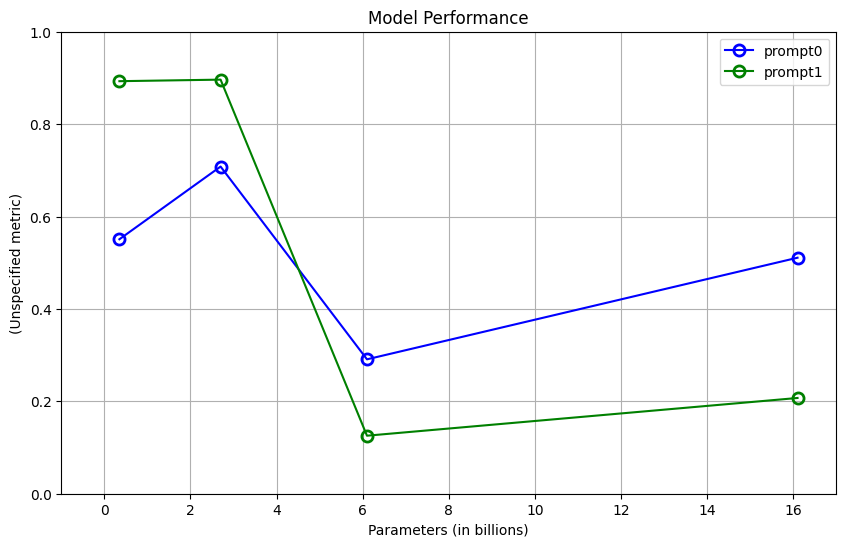

In [2]:
r = OutputRenderer(baseline=None)
np.random.seed(3)
r.render(
    ys = {
        "prompt0": np.random.random_sample(4),
        "prompt1": np.random.random_sample(4),
    }
)

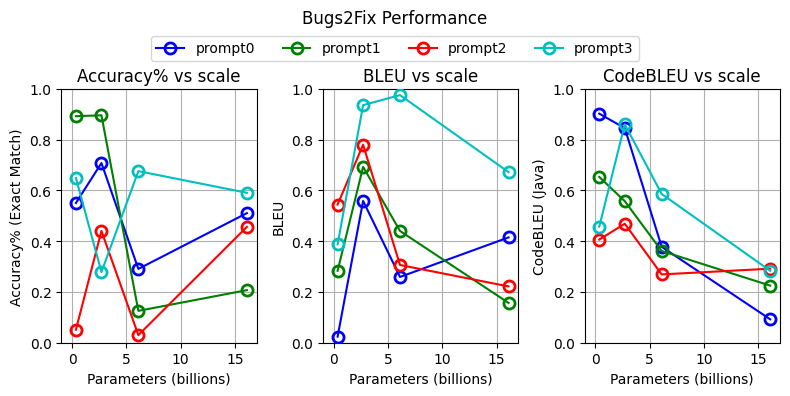

In [5]:
np.random.seed(3)
yss = []
metrics = [ metric.ExactMatch, metric.BLEU, metric.CodeBLEUJava ]
for i in range(3):
    yss.append({
        "prompt0": np.random.random_sample(4),
        "prompt1": np.random.random_sample(4),
        "prompt2": np.random.random_sample(4),
        "prompt3": np.random.random_sample(4),
    })
    
r = OutputRenderer(baseline=None)
r.render_multi(
    yss,
    metrics=[ metric.name for metric in metrics ],
    subtitles=[ f"{metric.simplename} vs scale" for metric in metrics ],
    dims=(1, 3),
    title="Bugs2Fix Performance",
)

## model testing

In [4]:
print("Importing torch...")
import torch
import torch.nn as nn
print("Importing HF...")
from transformers import AutoTokenizer, AutoModelForCausalLM
print("Importing python modules...")
from timehelp import time_start, time_end
from model_wrapper import Model, ModelFamily, MultipleChoiceStrategy
import re
print("Done!")

Importing torch...
Importing HF...
Importing python modules...
Done!


In [3]:
# options: 350M, 2B, 6B, 16B
model = Model(ModelFamily.CodeGen1.mono["350M"])
model.configure(time=True)

[2024-05-13@18:25:52|model.device] Starting timer.
Configuring torch device...
Using device: cuda:0 aka cuda:0
[2024-05-13@18:25:52|model.device] Time elapsed: 48ms
[2024-05-13@18:25:52|model.tokenizer] Starting timer.
[2024-05-13@18:25:52|model.tokenizer] Time elapsed: 222ms
[2024-05-13@18:25:52|model.model] Starting timer.
Obtaining model...
[2024-05-13@18:25:56|model.model] Time elapsed: 3s 300ms


In [4]:
prompt = """Python code:
for i in range(23):
    print(i)

  choice: prints 'hello world' to the terminal
  choice: prints values from 1 to 10
  choice: computes first 10 prime numbers
  choice: prints values from 0 to 22

English language description:"""

targets = re.findall(r"choice: (.+)", prompt)

print("Choices: ", targets)

Choices:  ["prints 'hello world' to the terminal", 'prints values from 1 to 10', 'computes first 10 prime numbers', 'prints values from 0 to 22']


In [25]:
targets.append("prints values from 1 to MAX_INT and explodes")
debug_info = model._tokenize_label(targets)
for i, tokens in debug_info:
    readable_tokens = (
        (
            model.decode(token.unsqueeze(0)),
            token.item()
        )
        for token
        in tokens[0]
    )
    print("|".join(raw_token for raw_token, token_idx in readable_tokens))
    #for raw_token, token_idx in readable_tokens:
    #    print(f" {raw_token!r} ({token_idx})")
    #print("\n" + "-" * 30)

prints| '|hello| world|'| to| the| terminal
prints| values| from| 1| to| 10
comp|utes| first| 10| prime| numbers
prints| values| from| 0| to| 22
prints| values| from| 1| to| MAX|_|INT| and| explodes


In [ ]:
idx = model.multiple_choice_prompts(
    prompt, targets,
    time=False,
    strategy=MultipleChoiceStrategy.MULTIPLY
)
print(idx, "--->", targets[idx])
# 350M FIRST_BRANCH: 2
# 350M LOGIT_AVERAGE: 1
# 350M MULTIPLY: 3

In [12]:
prompt = """Python code:
for i in range(23):
    print(i)

  choice: prints 'hello world' to the terminal
  choice: prints values from 1 to 10
  choice: computes first 10 prime numbers
  choice: prints values from 0 to 22

English language description:"""

targets = re.findall(r"choice: (.+)", prompt)

print("Choices: ", targets)

# target_tokens = [
#     (idx, model.tokenize(target)["input_ids"])
#     for idx, target in enumerate(targets)
# ]

inputs = model.tokenize(prompt)

with torch.no_grad():
    base_logits = None
    output = model.model(input_ids=inputs["input_ids"])
    base_logits = output.logits[:, -1, :]

    best_score = float("-inf")
    best_option = None
    
    for target in targets:
        print("Target:", target)
        target_tokens = model.tokenize(target)["input_ids"]
        print(target_tokens)
        #print([print(f"{x} -> {model.decode([ x ])!r}") for x in [x.item() for x in target_tokens[0]]])
        #break
        print("Base score:", base_logits[:, target_tokens[0, 0]])
        score = base_logits[:, target_tokens[0, 0]].item()
        running_inputs = inputs["input_ids"]

        print("initial score =", score)
        
        for idx in range(1, target_tokens.shape[1]):
            token = target_tokens[0, idx]
            token_formatted = token.unsqueeze(0).unsqueeze(0)
            running_inputs = torch.cat((running_inputs, token_formatted), dim=-1)
            output = model.model(input_ids=running_inputs)
            next_logits = output.logits[:, -1, :]
            print("Inner score:", next_logits[:, token])
            score += next_logits[:, token].item()

        print("Final score =", score)
        # does this even work
        score /= target_tokens.shape[1]
        print("Normalized =", score)
        
        if best_option is None or score > best_score:
            best_score = score
            best_option = target

        print()
        
    # if running_tensor is None:
    #     running_tensor = logits
    # else:
    #     running_tensor += logits

print("Best:", best_option, best_score)


if False:
    choice_idx, choice_tokens = model.multiple_choice_prompts(prompt, targets=choices)
    print("Most likely:", choices[choice_idx])

Choices:  ["prints 'hello world' to the terminal", 'prints values from 1 to 10', 'computes first 10 prime numbers', 'prints values from 0 to 22']
Target: prints 'hello world' to the terminal
tensor([[17190,   705, 31373,   995,     6,   284,   262, 12094]],
       device='cuda:0')
Base score: tensor([52.8601], device='cuda:0')
initial score = 52.8601188659668
Inner score: tensor([28.8365], device='cuda:0')
Inner score: tensor([116.5697], device='cuda:0')
Inner score: tensor([119.5772], device='cuda:0')
Inner score: tensor([109.8708], device='cuda:0')
Inner score: tensor([120.9642], device='cuda:0')
Inner score: tensor([109.5258], device='cuda:0')
Inner score: tensor([118.1730], device='cuda:0')
Final score = 776.3773574829102
Normalized = 97.04716968536377

Target: prints values from 1 to 10
tensor([[17190,  3815,   422,   352,   284,   838]], device='cuda:0')
Base score: tensor([52.8601], device='cuda:0')
initial score = 52.8601188659668
Inner score: tensor([119.6400], device='cuda:0'

In [17]:
model.multiple_choice_token("( False ) is ", ["True", "False"], time=True)

Tokenizing input prompt...
[2024-03-29@20:01:17|model.tokenize] Starting timer.
[2024-03-29@20:01:17|model.tokenize] Time elapsed: 2ms
Token count in input: 5


(0, 'True')

In [7]:
inputs = model.tokenize("def hello_world():")

Token count in input: 5


In [9]:
## FREE RESPONSE ##
sample = model.generate(inputs, time=True, max_new_tokens=64)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating...
[2024-03-29@19:52:39|model.generate] Starting timer.
[2024-03-29@19:52:42|model.generate] Time elapsed: 2s 568ms


In [11]:
print(model.decode(sample, inputs))


    print("Hello World")

hello_world()

# 파이썬의 내장 함수
# 파이썬의 내장 함수


In [138]:
def query_multiple_choice(model, inputs, targets):
    input_tokens = tokenizer(inputs, return_tensors="pt").to(use_device)
    
    with torch.no_grad():
        output = model(input_ids=input_tokens["input_ids"])
        logits = output.logits[:, -1, :]

    target_ids = tokenizer.convert_tokens_to_ids(targets)
    subset_logits = logits[:, target_ids]
    predicted_idx = torch.argmax(subset_logits, dim=-1).item()
    predicted_token = targets[predicted_idx]

    return predicted_idx, predicted_token

In [ ]:
time_start()
# print(tokenizer.decode(sample[0], truncate_before_pattern=[r"\n\n^#", "^'''", "\n\n\n"]))
print(tokenizer.decode(sample[:, inputs["input_ids"].shape[1]:][0]))
# print(tokenizer.decode(sample[0]))
time_end()